In [637]:
#Import statements 
import scipy
import scipy.linalg
from scipy.linalg import expm, norm, eigvals, solve
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from matplotlib import rc
import time
from sklearn.linear_model import LinearRegression


In [722]:
pip install nbconvert

Note: you may need to restart the kernel to use updated packages.


In [575]:
#Fonts and stuff 
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [ ]:
#2.

In [591]:
#2.1 Implementation of RK4step function
def RK4step(f, told, uold, h):
    """Takes a single step with the classical RK4 method
    param f: np.ndarray. Function that descripes differential equation
    param told: float. time at step
    param uold: float. value of y at told
    param h: float. Stepsize
    return: the value(s) of y at n+1"""
    Y1 = f(told,uold)
    Y2 = f(told + h/2, uold + h*Y1/2)
    Y3 = f(told + h/2, uold + h*Y2/2)
    Y4 = f(told + h, uold + h*Y3)
    return uold + h/6*(Y1 + 2*Y2 + 2*Y3 + Y4)

In [590]:
#2.1 Implementation of Lte class
class Lte():
    """Linear test function/equation class to be used for testing RK4step
    the function simply multiplies another function with a scalar lamb
    param lamb: float"""
    
    
    def __init__(self, lamb):
        self.lamb = lamb
        
    def set_lamb(self, lamb):
        self.lamb = lamb
        
    def ltf(self, t, y):
        """"Applies the linear test function to the object y
        param t, float. Just here for matching arguments with RK4step
        param y, np.ndarray. vector or scalar value for the function that lte is applied to at time t
        """
        return self.lamb*y

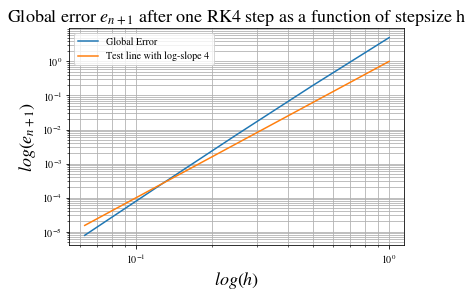

In [713]:
#2.1 use the linear test equation y 0 = λy, and verify that the global error is O(h4) by plotting the error in a
#log log diagram

#Define starting value and time, create linear test function(in this case lambda = 10), try some different stepsizes
f = Lte(-4)
y0 = 1
t0 = 0
h = [2**-n for n in range(5)]
error = []
test = []
#for every choice of stepsize, calculate approximate y1 from RK4step, calculate y using explicit formula
#see what the error is, hopefully it goes like O(h^4) or faster. A test line is plotted to see if the error gets a
#log log slope of 4 or greater
for i in range(len(h)):
    y1 = RK4step(f.ltf, t0, y0, h[i])
    y1_exact = y0 * np.exp((t0+h[i])*f.lamb)
    error.append(norm(np.array([y1])-np.array([y1_exact]), ord = 2))
    test.append(h[i]**4)

    
plt.loglog(h, error, label = 'Global Error')
plt.loglog(h,test, label = 'Test line with log-slope 4')
plt.xlabel('$log(h)$', fontsize = 18)
plt.ylabel('$log(e_{n+1})$', fontsize = 18)
plt.title('Global error $e_{n+1}$ after one RK4 step as a function of stepsize h', fontsize = 18)
plt.legend()
plt.grid(True, which = "both")

In [584]:
#2.2 implementation of RK34step function
def RK34step(f, told, uold, h):
    """Takes a single step with the classical RK34 method. Calculates and returns y at next step and 
    the local error. Uses the slow way of computing local error doing all the steps.
    param f: object.Lte. Function that descripes differential equation. in our case an Lte function
    param told: float. time at step
    param uold: float. value of y at told
    param h: float. Stepsize
    return y: the value of y at n+1
    return y-z: the local error at n+1 
    """
    Y1 = f(told,uold)
    Y2 = f(told + h/2, uold + h/2*Y1)
    Y3 = f(told + h/2, uold + h/2*Y2)
    Z3 = f(told + h, uold - h*Y1 + 2*h*Y2)
    Y4 = f(told + h, uold + h*Y3)
    y = uold + h/6*(Y1 + 2*Y2 + 2*Y3 + Y4)
    z = uold + h/6*(Y1+4*Y2 + Z3)
    return y, z-y

In [586]:
#2.3 Implementation of the newstep function
def newstep(tol, err, errold, hold, k):
    """Computes and returns the new step size given the parameters. The new stepsize ensures an error less than tol
    param tol: float, the tolerated error
    param err: float, local error estimate
    param errold: float, previous error estimate
    param hold: float, the old step size
    param k: int, the order of the error estimator
    return hnew: float, the new stepsize"""
    
    
    return (tol/err)**(2/(3*k)) * (tol/errold)**(-1/(3*k)) * hold


In [592]:
#2.4 Implementation of the adaptiveRK34 solver function
def adaptiveRK34(f, t0, tf, y0, tol, return_errors = False, count_steps = False):
    """Adaptive ODE solver. Solves an ODE on the form y' = f(t,y) numerically using adaptive RK34 method with an error
    that is bounded by the parameter tol
    param f: object. The function on the left in the ODE
    param t0; float, initial time
    param tf: float, final time
    param y0: float, initial value of y
    param tol: float, tolerated maximum global error
    param return_errors: bool, (optional) set to True if we want the errors returned
    param count_steps: bool, (optional) set to True if we want number of steps returned
    return ys,errors,t,len(h): np.ndarray: the numerical solution, the errors, the grid that the ODE is solved on, n.o steps"""
    #initialize constants
    k = 4
    ys = [np.array(y0)]
    h0 = np.abs(tf-t0) * tol**(1/4) / (100 * (1 + norm(f(t0,ys[0]))))
    errors = [tol]
    hs = [h0]
    t = [t0]
    #Loop until we try to overshoot t final. If another step overshoots the interval, stop.
    while t[-1] + hs[-1] < tf:
        ynew, errornew = RK34step(f, t[-1], ys[-1], hs[-1])
        errornew = norm(errornew, ord=2)
        t.append(t[-1]+hs[-1])
        hnew = newstep(tol,errornew, errors[-1], hs[-1], k)
        if(hnew + t[-1]>tf):
            hnew = tf-t[-1]
        ys = np.vstack((ys, ynew))
        hs.append(hnew)
        errors.append(errornew)
    #calculate last step size and subsequently calculate ys value and the error at time tf Remaining "distance" to finish
    ynew, errornew = RK34step(f, t[-1], ys[-1], hs[-1])
    t.append(tf)
    ys = np.vstack((ys, ynew))
    errors.append(errornew)
    if return_errors:
        return ys, errors, t
    elif count_steps:
        return ys, t, len(hs)
    else:
        return ys,t
    

In [593]:
#3.1 Implementation of Lotka-Volterra equation
class Lotka_Volterra():
    """Lotka volterra equation/function class. contains functions for evaluating H(x,y) and dudt
    param a,b,c,d: float. Constants in the Lotka-Volterra equation"""
    
    def __init__(self,a,b,c,d):
        self.a = a
        self.b = b
        self.c = c
        self.d = d
    
    
    def dudt(self, t, u):
        """calculates and returns the derivative of the vector u with respect to time 
        param t: float, the time. Not used, just for argument matching
        param u: np.ndarray. The vector [x,y] note that the order matters
        return: np.ndarray, the time derivate of x,y at t"""
        return np.array([self.a*u[0] - self.b*u[0]*u[1],
                self.c*u[0]*u[1] - self.d*u[1]])
    
    def H(self, x, y):
        """calculates and returns the value of the H function in task 3.1 
        param x: float array like
        param y: float array like
        return H(x,y): float array like. value of H at x,y"""
        return self.c*np.array(x) + self.b*np.array(y) - self.d*np.log(np.array(x)) - self.a*np.log(np.array(y))
    
        
        

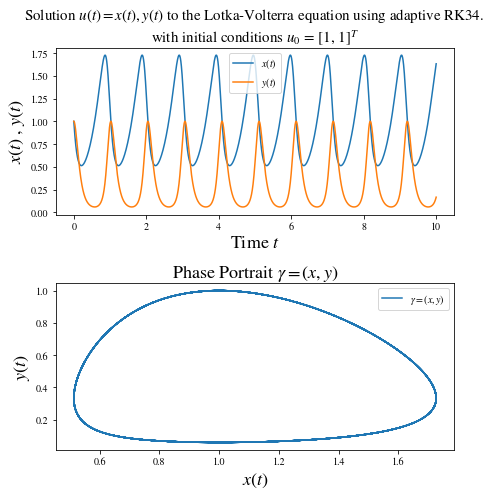

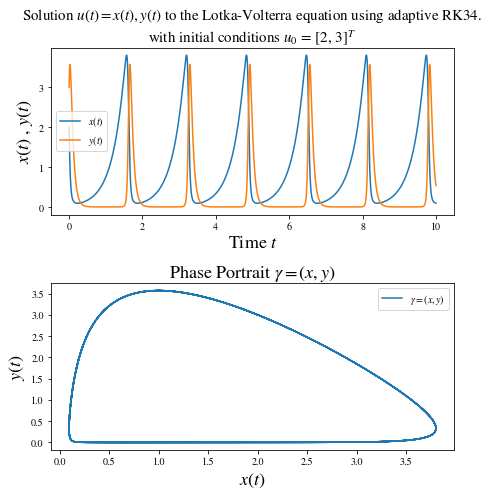

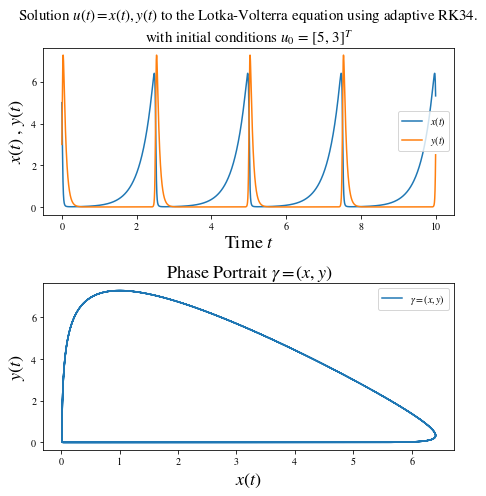

In [700]:
###Plot the solution to lotka_volterra for different initial conditions
lv = Lotka_Volterra(3, 9, 15, 15)
u0s = [[1,1],[2,3],[5,3]]
tol = 1e-8
t0 = 0
tf = 10

for u0 in u0s:
    u, t = adaptiveRK34(lv.dudt, t0, tf, u0, tol)
    fig1, (axis1, axis2) = plt.subplots(nrows=2, figsize=[7, 7], tight_layout=True)
    axis1.plot(t,u[:,0], label = "$x(t)$")
    axis1.plot(t,u[:,1], label = "$y(t)$")
    axis1.set_title("Solution $u(t)=x(t),y(t)$ to the Lotka-Volterra equation using adaptive RK34. \n"
    + "with initial conditions $u_0$ = " + str(u0) + "$^T$", fontsize = 15)
    axis1.legend()
    axis1.set_xlabel("Time $t$", fontsize = 18)
    axis1.set_ylabel("$x(t)$ , $y(t)$", fontsize = 18)
    
    
    axis2.set_title("Phase Portrait $\gamma = (x,y)$", fontsize = 18)
    axis2.set_xlabel("$x(t)$", fontsize = 18)
    axis2.set_ylabel("$y(t)$", fontsize = 18)
    axis2.plot(u[:,0],u[:,1], label = "$\gamma = (x,y)$")
    axis2.legend()

    

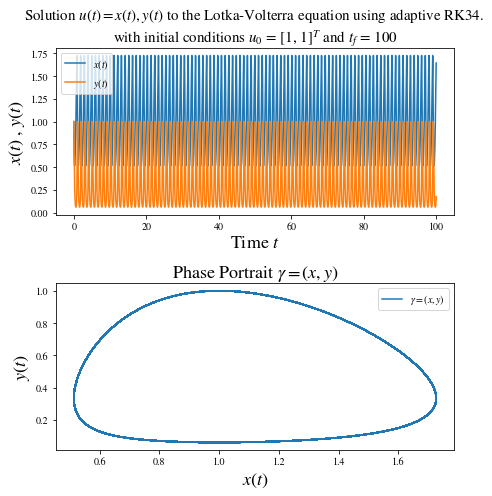

In [703]:
###Integrate over very long time
lv = Lotka_Volterra(3, 9, 15, 15)
u0 = [1,1]
tol = 1e-8
t0 = 0
tf = 100
u, t = adaptiveRK34(lv.dudt, t0, tf, u0, tol)
fig1, (axis1, axis2) = plt.subplots(nrows=2, figsize=[7, 7], tight_layout=True)
axis1.plot(t,u[:,0], label = "$x(t)$")
axis1.plot(t,u[:,1], label = "$y(t)$")
axis1.set_title("Solution $u(t)=x(t),y(t)$ to the Lotka-Volterra equation using adaptive RK34. \n"
    + "with initial conditions $u_0$ = " + str(u0) + "$^T$ and $t_f$ = 100", fontsize = 15)
axis1.legend()
axis1.set_xlabel("Time $t$", fontsize = 18)
axis1.set_ylabel("$x(t)$ , $y(t)$", fontsize = 18)


axis2.set_title("Phase Portrait $\gamma = (x,y)$", fontsize = 18)
axis2.set_xlabel("$x(t)$", fontsize = 18)
axis2.set_ylabel("$y(t)$", fontsize = 18)
axis2.plot(u[:,0],u[:,1], label = "$\gamma = (x,y)$")
axis2.legend();


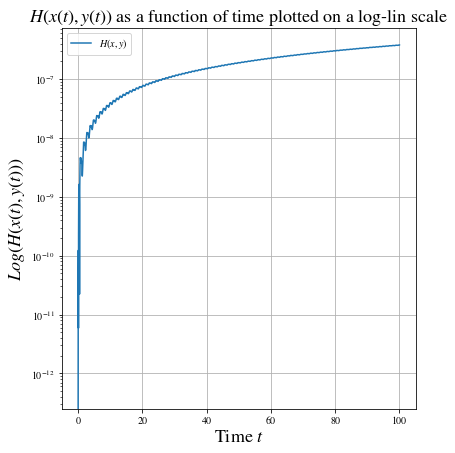

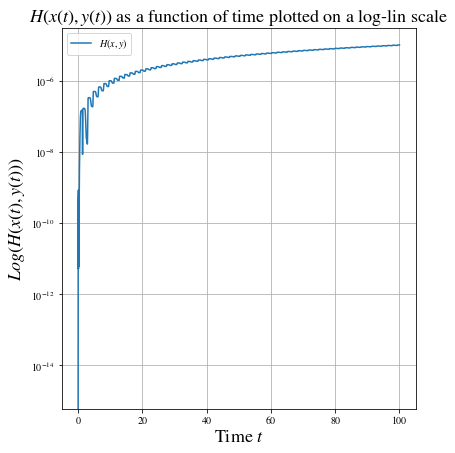

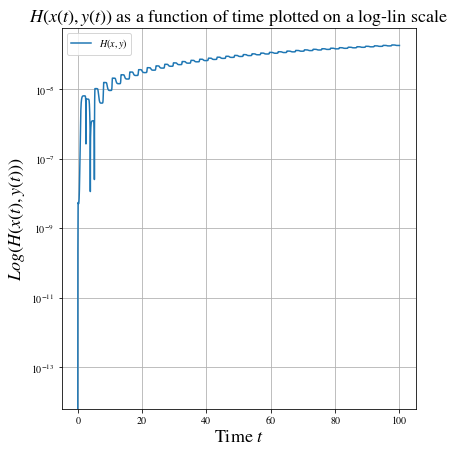

In [627]:
##Check if H remains constant

lv = Lotka_Volterra(3, 9, 15, 15)
u0s = [[1,1],[2,3],[5,4]]
tol = 1e-8
t0 = 0
tf = 100

for u0 in u0s:
    u, t = adaptiveRK34(lv.dudt, t0, tf, u0, tol)
    fig1, axis1 = plt.subplots(nrows=1, figsize=[6.4, 6.4], tight_layout=True)
    axis1.semilogy(t, np.abs(lv.H(u[:,0], u[:,1])/lv.H(u0[0],u0[1])-1), label = "$H(x,y) $")
    axis1.set_title("$H(x(t),y(t))$ as a function of time plotted on a log-lin scale", fontsize = 18)
    axis1.legend()
    axis1.set_xlabel("Time $t$", fontsize = 18)
    axis1.set_ylabel("$Log(H(x(t),y(t)))$", fontsize = 18)
    axis1.grid()
    


In [638]:
###4

In [628]:
#4.1 Implementation of van der pol equation
class Van_der_pol():
    """Van der pol equation class for creating van der pol objects that have the function dudt
    that are used in RK34 solver"""
    
    def __init__(self, mu):
        self.mu = mu
        
    def dudt(self, t, u):
        """Computes and returns the time derivate of u
        param t: float. Not used, just for matching arguments
        param u: np.ndarray, the function that is evaluated in the van der pol equation must be on the format 
        [y_1, y_2]
        return dudt: np.ndarray, the value of the time derivates at t"""
        
        return np.array([u[1]
                        , self.mu * (1-u[0]**2) * u[1] - u[0]])


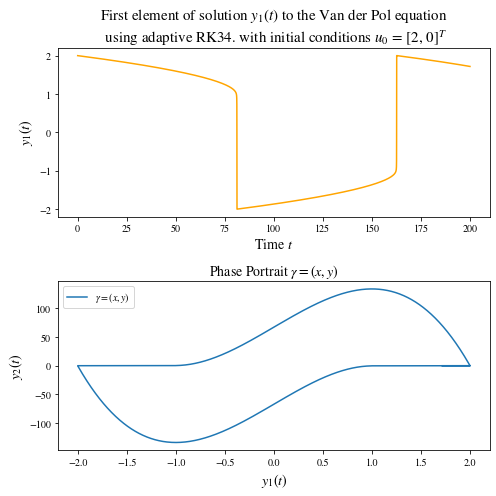

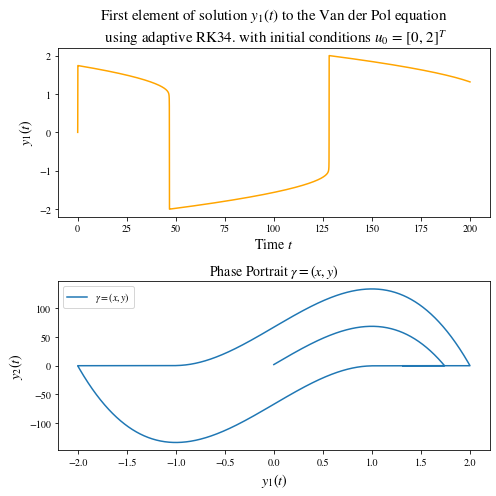

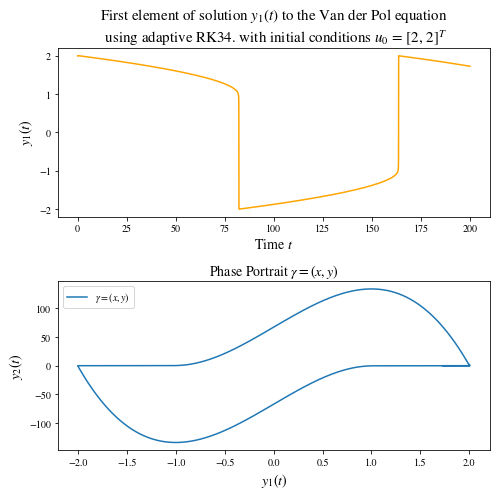

In [720]:
#4.1 Solve van der pol on interval [0,2mu]
mu = 100
vdp = Van_der_pol(mu)
u0s = [[2,0],[0,2],[2,2]]
tol = 1e-8
t0 = 0
tf = 2*mu

for u0 in u0s:
    u, t = adaptiveRK34(vdp.dudt, t0, tf, u0, tol)
    fig1, (axis1, axis2) = plt.subplots(nrows=2, figsize=[7, 7], tight_layout=True)
    axis1.plot(t,u[:,0], label = "$y_1(t)$", color = "orange")
    axis1.set_title("First element of solution $y_1(t)$ to the Van der Pol equation \n"
    + " using adaptive RK34. with initial conditions $u_0$ = " + str(u0) + "$^T$", fontsize = 15)
    axis1.set_xlabel("Time $t$", fontsize = 14)
    axis1.set_ylabel("$y_1(t)$", fontsize = 14)
    
    
    axis2.plot(u[:,0],u[:,1], label = "$\gamma = (x,y)$")
    axis2.set_title("Phase Portrait $\gamma = (x,y)$", fontsize = 14)
    axis2.set_xlabel("$y_1(t)$", fontsize = 14)
    axis2.set_ylabel("$y_2(t)$", fontsize = 14)
    axis2.legend()
plt.savefig("/Users/nils/Desktop/vdp4")
    

Execution time: 153.4624478816986 seconds


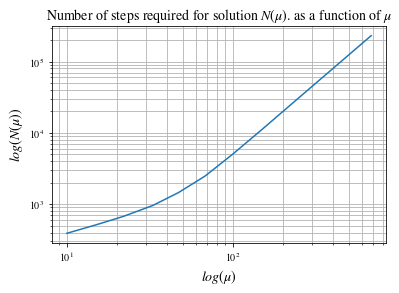

In [647]:
#4.2 how stiffnes depends on mu
start = time.time()
mus = [10,15,22,33,47,68,100,150,220,330,470,680]
N = []

#Test how many steps are required to solve the van der pol equation for different values of the van der pol parameter
for mu in mus:
    vdp = Van_der_pol(mu)
    f = vdp.dudt
    u0 = [2,0]
    tol = 1e-8
    t0 = 0
    tf = 0.7*mu
    _,_,steps = adaptiveRK34(f, t0, tf, u0, tol, count_steps = True)
    N.append(steps)
    
plt.loglog(mus, N)
plt.title("Number of steps required for solution $N(\mu)$. as a function of $\mu$" , fontsize = 14)
plt.xlabel("$log(\mu)$", fontsize = 14)
plt.ylabel("$log(N(\mu))$", fontsize = 14)
plt.grid(True, which='both')


end = time.time()
print("Execution time: " + str(end-start) + " seconds")

Linear regression on intervall μ ∈ [ 68,680 ] log(N) = C + qlog(μ) gives q = 1.9782350685344399


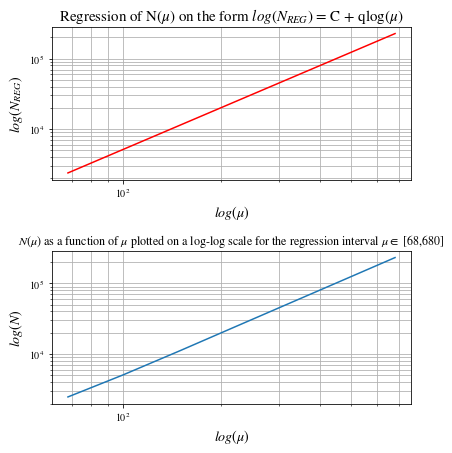

In [680]:
#N(mu) seems to be linear if mu is big enough, therefore we exclude the first 4 elements. We perform a log 
#linear regression since N = C*mu^q -> log(N) = C + qlog(mu)

mui = 5 ###the first mu we want to start the regression on


reg = LinearRegression().fit(np.log(mus[mui:]).reshape(-1,1), np.log(N[mui:]).reshape(-1,1)) #linear regression using scikit learn
k = reg.coef_[0][0]
m = reg.intercept_[0]
fig1, (axis1, axis2) = plt.subplots(nrows=2, figsize=[6.4, 6.4], tight_layout=True)

axis1.loglog(mus[mui:], np.abs(m)*mus[mui:]**k, color = 'red')
axis1.set_title("Regression of N($\mu$) on the form $log(N_{REG})$ = C + qlog($\mu$) ", fontsize = 15)
axis1.set_xlabel("$log(\mu)$", fontsize = 14)
axis1.set_ylabel("$log(N_{REG})$", fontsize = 14)
axis1.grid(True, which='both') 
    
axis2.loglog(mus[mui:], N[mui:])
axis2.set_title("$N(\mu)$ as a function of $\mu$ plotted on a log-log scale for the regression interval $\mu \in$ [" + str(mus[mui]) + "," + str(mus[-1]) + "] ", fontsize = 12)
axis2.set_xlabel("$log(\mu)$", fontsize = 14)
axis2.set_ylabel("$log(N)$", fontsize = 14)
axis2.grid(True, which='both') 


print("Linear regression on intervall μ ∈ [ " + str(mus[mui]) + "," + str(mus[-1]) + " ] log(N) = C + qlog(μ) gives q = " + str(k))

Execution time: 0.2775847911834717 seconds


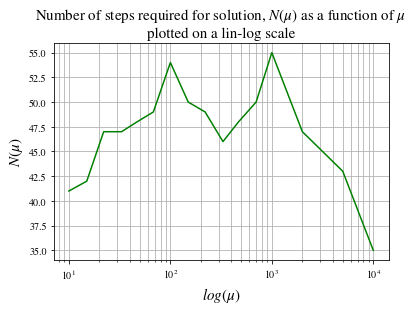

In [712]:
#4.3 
start = time.time()
u0 = [2,0]
t0 = 0
tol = 1e-6
mus = [10, 15, 22, 33, 47, 68, 100, 150, 220, 330, 470, 700, 1000, 2000, 5000, 10000]
N = []
for mu in mus:
    vdp = Van_der_pol(mu)
    f = vdp.dudt
    
    tf = 0.7*mu
    solution = solve_ivp(f, (t0, tf), u0, atol = tol, method = 'BDF')
    N.append(len(solution['t']))
    
plt.semilogx(mus, N, color="green")
plt.title("Number of steps required for solution, $N(\mu)$ as a function of $\mu$ \n"
          + "plotted on a lin-log scale", fontsize = 15)
plt.xlabel("$log(\mu)$", fontsize = 15)
plt.ylabel("$N(\mu)$", fontsize = 15)
plt.grid(True, which='both')

end = time.time()
print("Execution time: " + str(end-start) + " seconds")